In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import PchipInterpolator, CubicSpline, UnivariateSpline
from scipy.optimize import minimize_scalar, differential_evolution

import math

from easygsvd import gsvd as gsvd_func
from easygsvd import random_rank_matrix

import jlinops

import os
import sys
sys.path.append("../..")

from scipy.sparse.linalg import aslinearoperator

from pytikhonov import lcorner, TikhonovFamily, discrepancy_principle, lcorner, find_lcurve_corner, plot_rdata, picard_plot, gcvmin, all_regparam_methods
from pytikhonov import rand_discrepancy_principle, rand_lcurve, rand_lcorner, rand_gcvmin
from pytikhonov import plot_gcv, plot_dp, plot_lcorner, plot_all_methods, picard_plot
from pytikhonov import golub_kahan
from pytikhonov import estimate_noise_variance, plot_monitoring_function

from pytikhonov import ProjectedTikhonovFamily

In [ ]:
# Problem parameters
blur_sigma = 8.0

xtrue = jlinops.piecewise_constant_1d_test_problem()
N = len(xtrue)
A = jlinops.Gaussian1DBlurOperator(N, blur_sigma=blur_sigma, mode="constant")
A = jlinops.black_box_to_dense(A)
#A = A[::2,:]
noise_sigma = 1e-1
btrue = A @ xtrue
np.random.seed(0)
noise_vec = noise_sigma*np.random.normal(size=len(btrue))
b = btrue + noise_vec  # signal and noise
#b = noise_vec.copy() # pure noise
L, _ = jlinops.first_order_derivative_1d(N, boundary="zero")
L = L.toarray()


# Should we do L1?
do_l1 = False
if do_l1:
    def mm_weights(x, epsilon, p):
        z = (x**2 + epsilon**2)**( (p-2.0)/2.0 )
        return z

    l1_epsilon = 1e-3
    l1_weighting_rule = lambda Lx, lambdah: np.sqrt(mm_weights(Lx, l1_epsilon, 1.0))
    w_true = l1_weighting_rule(L @ xtrue, 1.0)
    L = np.diag(w_true) @ L



# define tikhonov family
tf = TikhonovFamily(A, L, b, None, btrue=btrue, noise_var=noise_sigma**2)
gsvd = tf.gsvd

In [15]:
tf_no_noise = TikhonovFamily(A, L, btrue, None, btrue=None, noise_var=None)

In [16]:
dp_data = discrepancy_principle(tf, delta=np.sqrt(A.shape[0])*noise_sigma )

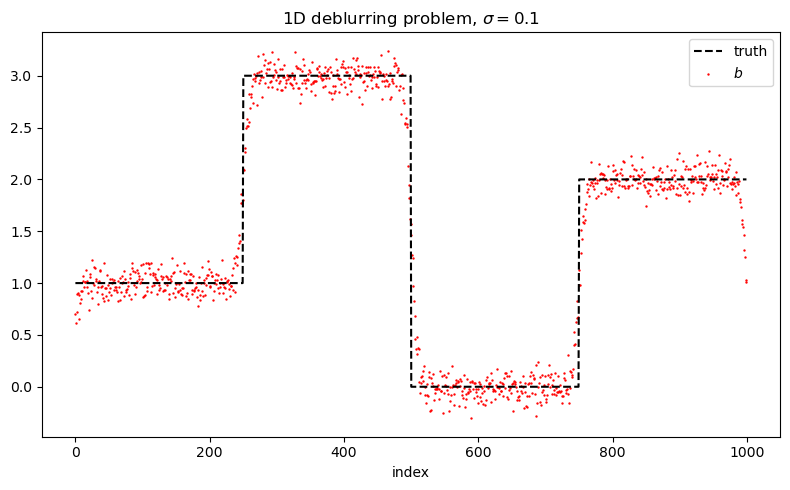

In [5]:
idx = [i for i in range(len(b))]
plt.figure(figsize=(8,5))
plt.plot(xtrue, label="truth", ls="--", color="k")
plt.scatter(idx, b, label="$b$", color="red", s=0.5)
plt.legend()
plt.xlabel("index")
plt.title(f"1D deblurring problem, $\sigma = {noise_sigma}$")
#plt.plot(dp_data["x_lambdah"], color="blue", label="DP solution")
plt.tight_layout()
plt.savefig("deblur_data.png", dpi=250, bbox_inches=None)
plt.show()

# Call Tikhonov family

In [6]:
tf = TikhonovFamily(A, L, b, None, btrue=btrue, noise_var=noise_sigma**2)
tf_novar = TikhonovFamily(A, L, b, None, btrue=None, noise_var=None)

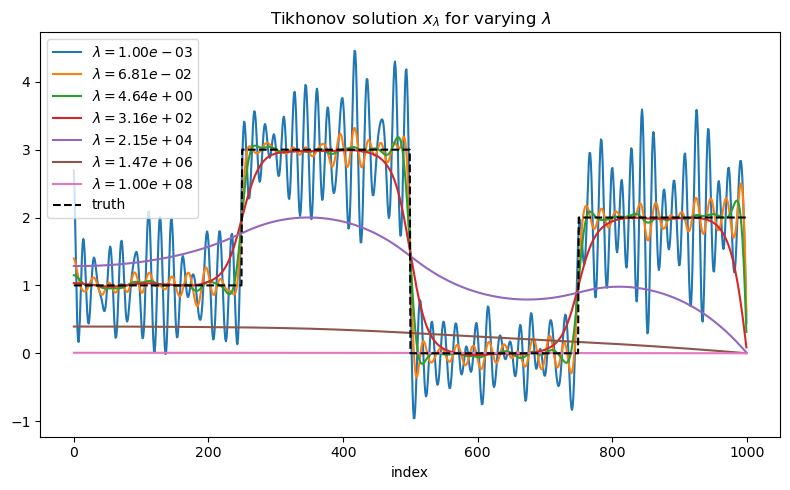

In [13]:
idx = [i for i in range(len(b))]
plt.figure(figsize=(8,5))
lambdahs = np.logspace(-3, 8, num=7, base=10)


for lam in lambdahs:
    plt.plot(idx, tf.solve(lam), label=f"$\lambda = {lam:.2e}$")

plt.plot(xtrue, label="truth", ls="--", color="k")
#plt.scatter(idx, b, label="$b$", color="red", s=0.5)
plt.legend()
plt.xlabel("index")
plt.title(f"Tikhonov solution $x_{{\lambda}}$ for varying $\lambda$")
#plt.plot(dp_data["x_lambdah"], color="blue", label="DP solution")
plt.tight_layout()
plt.savefig("deblur_tf.png", dpi=250, bbox_inches=None)
plt.show()

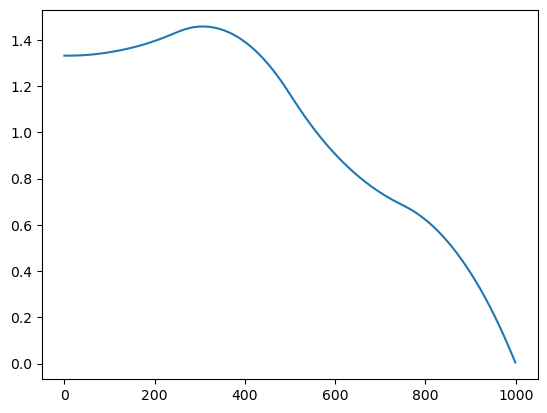

In [10]:
plt.plot(tf.solve(1e5))
plt.show()

In [24]:
lambdahs = np.logspace(-3, 3, num=7, base=10)

In [25]:
data_fidelities = tf.data_fidelity(lambdahs, reciprocate=False)
regularization_terms = tf.regularization_term(lambdahs, reciprocate=False)

In [26]:
# Derivatives
order = 1

data_fidelities_derivs = tf.data_fidelity_derivative(lambdahs, order=1, reciprocate=False)
regularization_terms_derivs = tf.regularization_term_derivative(lambdahs, order=1, reciprocate=False)

data_fidelities_derivs = tf.data_fidelity_derivative(lambdahs, order=1, reciprocate=False)
regularization_terms_derivs = tf.regularization_term_derivative(lambdahs, order=1, reciprocate=False)

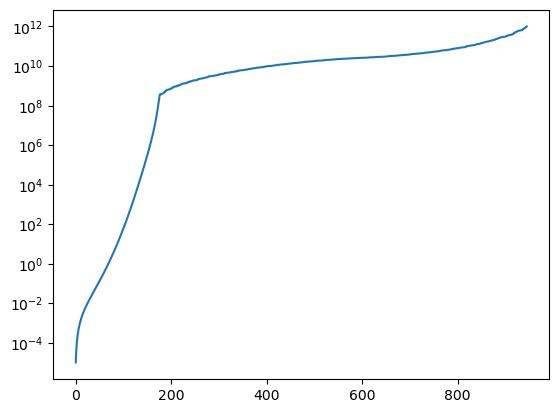

In [31]:
plt.semilogy(1.0/(tf.gsvd.gamma_check**2))

# Plot the L-curve?

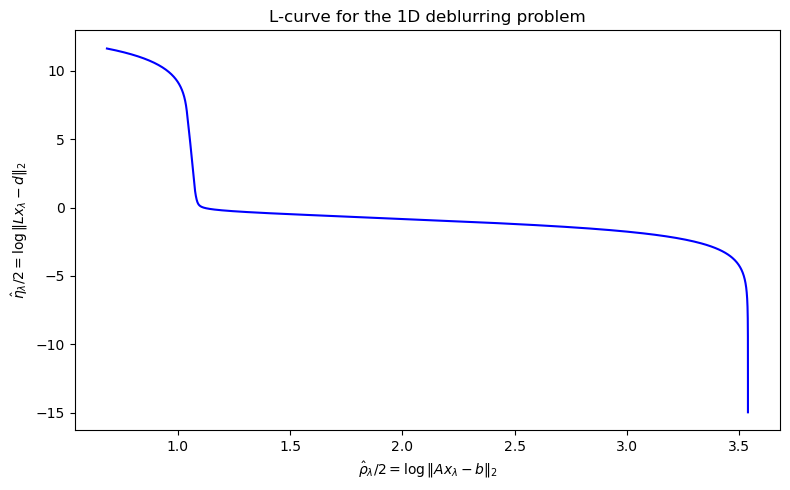

In [10]:
lambdahs = np.logspace(-10, 10, num=1000, base=10)
rho_hat_half, eta_hat_half = tf.lcurve(lambdahs)

plt.figure(figsize=(8,5))
plt.plot(rho_hat_half, eta_hat_half, color="blue")
plt.xlabel("$\hat{\\rho}_{\lambda}/2 = \log \| A x_{\lambda} - b \|_2$")
plt.ylabel("$\hat{\\eta}_{\lambda}/2 = \log \| L x_{\lambda} - d \|_2$")
plt.title("L-curve for the 1D deblurring problem")
plt.tight_layout()
plt.savefig("deblur_lcurve.png", dpi=250, bbox_inches=None)
plt.show()

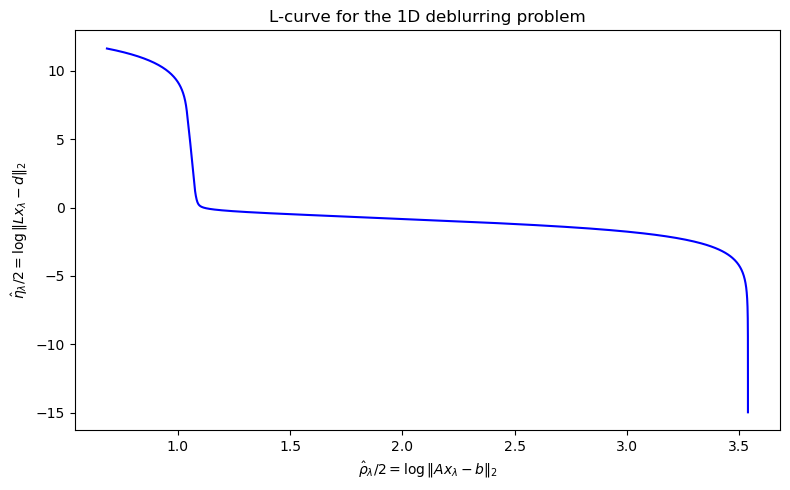

In [11]:
lambdahs = np.logspace(-10, 10, num=1000, base=10)
rho_hat_half, eta_hat_half = tf.lcurve(lambdahs)

plt.figure(figsize=(8,5))
plt.plot(rho_hat_half, eta_hat_half, color="blue")
plt.xlabel("$\hat{\\rho}_{\lambda}/2 = \log \| A x_{\lambda} - b \|_2$")
plt.ylabel("$\hat{\\eta}_{\lambda}/2 = \log \| L x_{\lambda} - d \|_2$")
plt.title("L-curve for the 1D deblurring problem")
plt.tight_layout()
plt.savefig("deblur_lcurve.png", dpi=250, bbox_inches=None)
plt.show()

In [12]:
tf_pure_noise = TikhonovFamily(A, L, noise_vec, None, btrue=btrue, noise_var=noise_sigma**2)
tf_pure_signal = TikhonovFamily(A, L, btrue, None, btrue=btrue, noise_var=noise_sigma**2)

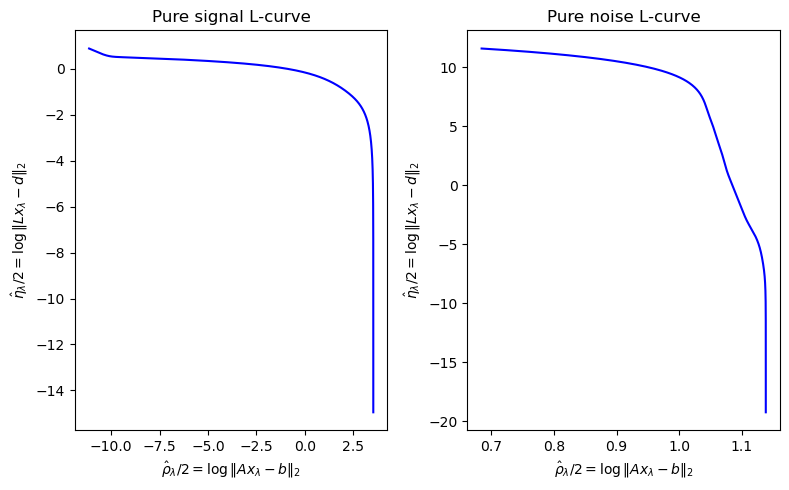

In [13]:
lambdahs = np.logspace(-10, 10, num=1000, base=10)

fig, axs = plt.subplots(1, 2, figsize=(8,5))

rho_hat_half, eta_hat_half = tf_pure_noise.lcurve(lambdahs)
axs[1].plot(rho_hat_half, eta_hat_half, color="blue")
axs[1].set_xlabel("$\hat{\\rho}_{\lambda}/2 = \log \| A x_{\lambda} - b \|_2$")
axs[1].set_ylabel("$\hat{\\eta}_{\lambda}/2 = \log \| L x_{\lambda} - d \|_2$")
axs[1].set_title("Pure noise L-curve")

rho_hat_half, eta_hat_half = tf_pure_signal.lcurve(lambdahs)
axs[0].plot(rho_hat_half, eta_hat_half, color="blue")
axs[0].set_xlabel("$\hat{\\rho}_{\lambda}/2 = \log \| A x_{\lambda} - b \|_2$")
axs[0].set_ylabel("$\hat{\\eta}_{\lambda}/2 = \log \| L x_{\lambda} - d \|_2$")
axs[0].set_title("Pure signal L-curve")


fig.tight_layout()
fig.savefig("deblur_lcurve_pure_noise_signal.png", dpi=250, bbox_inches=None)
plt.show()

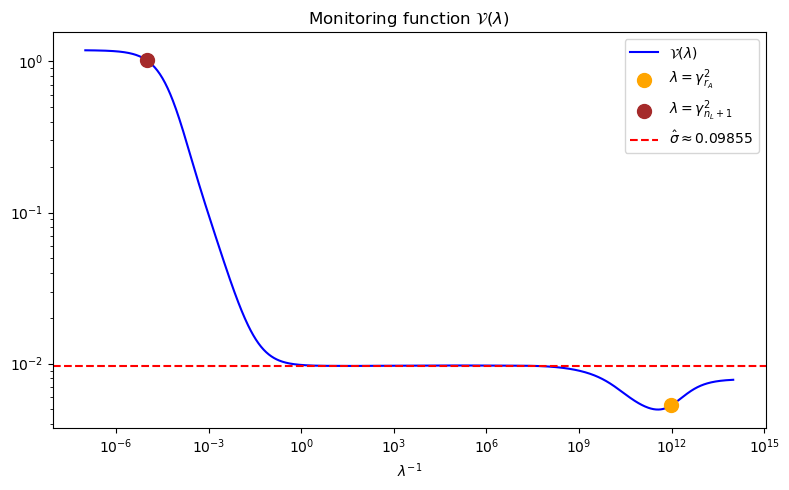

In [14]:
plot_monitoring_function(tf, plot_path="deblur_monitoring_func.png")
plot_monitoring_function(tf, plot_path=None)

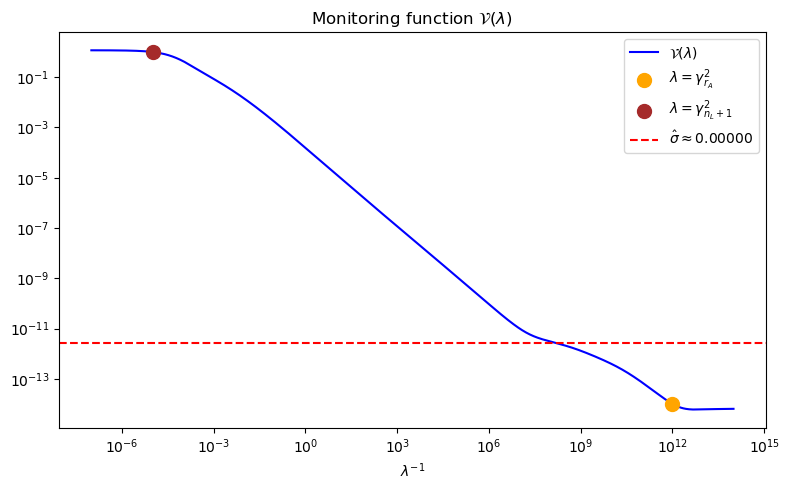

In [16]:
#plot_monitoring_function(tf, plot_path="deblur_monitoring_func.png")
plot_monitoring_function(tf_no_noise, plot_path=None)

In [15]:
estimate_noise_variance(tf)

0.009712696608389637

In [16]:
noise_sigma**2

0.010000000000000002

# Picard plot

In [17]:
picard_plot(tf, plot_path="deblur_picard.png")
picard_plot(tf_novar, plot_path="deblur_picard_novar.png")

# L-corner

In [18]:
ldata = lcorner(tf)

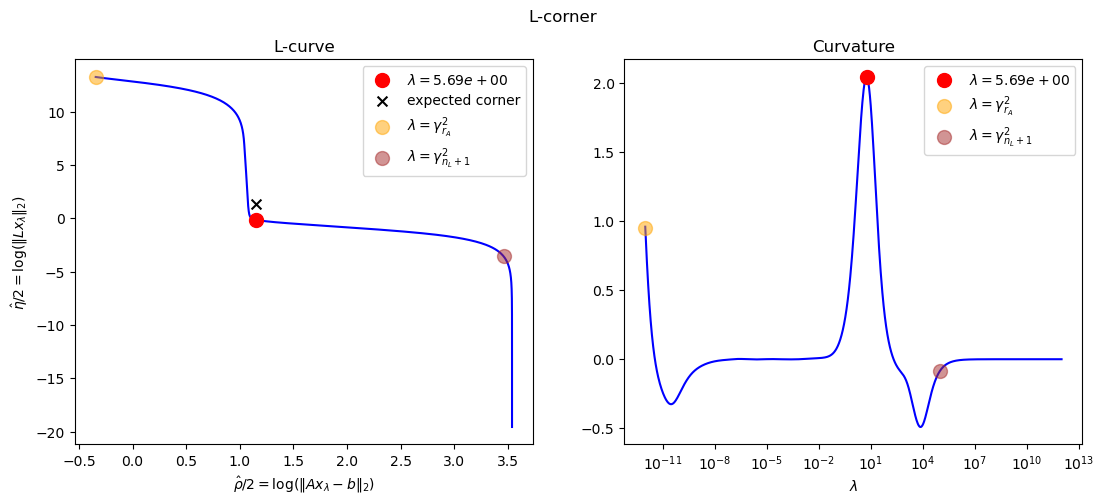

In [19]:
plot_lcorner(ldata, plot_path="deblur_lcorner.png")
plot_lcorner(ldata, plot_path=None)

# DP method

In [12]:
# noise_var_est = estimate_noise_variance(tf_novar)
# # dp_data = discrepancy_principle(tf_novar, delta=np.sqrt(A.shape[0]*noise_var_est) )

In [11]:
dp_data = discrepancy_principle(tf)

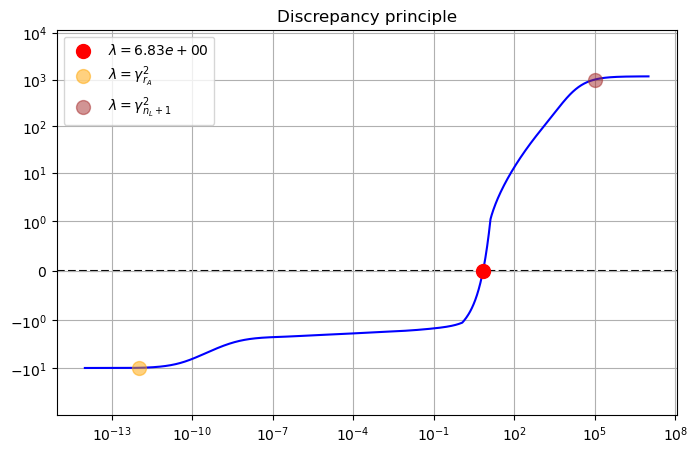

In [12]:
plot_dp(dp_data, plot_path="deblur_dp.png")
plot_dp(dp_data, plot_path=None)

In [15]:
dp_data["opt_rho_hat"]

2.322485754700382

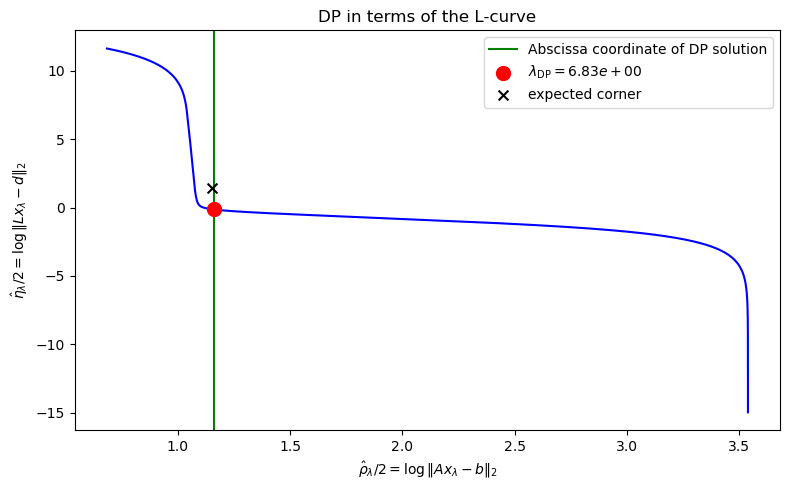

In [27]:
lambdahs = np.logspace(-10, 10, num=1000, base=10)
rho_hat_half, eta_hat_half = tf.lcurve(lambdahs)



plt.figure(figsize=(8,5))
plt.plot(rho_hat_half, eta_hat_half, color="blue")
plt.xlabel("$\hat{\\rho}_{\lambda}/2 = \log \| A x_{\lambda} - b \|_2$")
plt.ylabel("$\hat{\\eta}_{\lambda}/2 = \log \| L x_{\lambda} - d \|_2$")
plt.title("DP in terms of the L-curve")
plt.axvline(0.5*np.log(A.shape[0]*(noise_sigma**2)*(1.01**2)), color="green", label="Abscissa coordinate of DP solution")
opt_lambdah = dp_data["opt_lambdah"]
plt.scatter(dp_data["opt_rho_hat"]/2.0, dp_data["opt_eta_hat"]/2.0, color="red", s=100, zorder=10, label=f"$\lambda_{{\\text{{DP}}}} = {opt_lambdah:.2e}$")
plt.scatter( 0.5*np.log(  (A.shape[0] - tf.n_L)*(noise_sigma**2)  ), 0.5*np.log( tf.d_hat_perp_norm_squared + (((tf.U2.T @ btrue)**2)/(tf.gamma_check**2)).sum() ) , s=50, zorder=10, color="black", marker="x", label="expected corner" )
plt.legend()
plt.tight_layout()
plt.savefig("deblur_lcurve_with_dp.png", dpi=250, bbox_inches=None)
plt.show()

# GCV

In [7]:
gcv_data = gcvmin(tf)

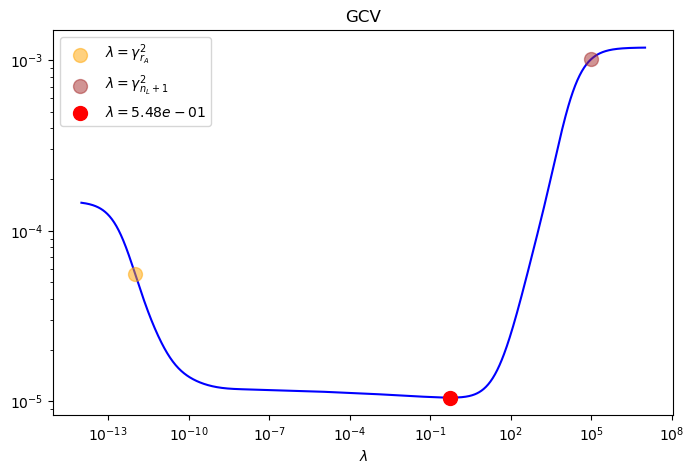

In [9]:
plot_gcv(gcv_data, plot_path="deblur_gcv.png")
plot_gcv(gcv_data, plot_path=None)

# All methods

In [11]:
all_methods = all_regparam_methods(tf)

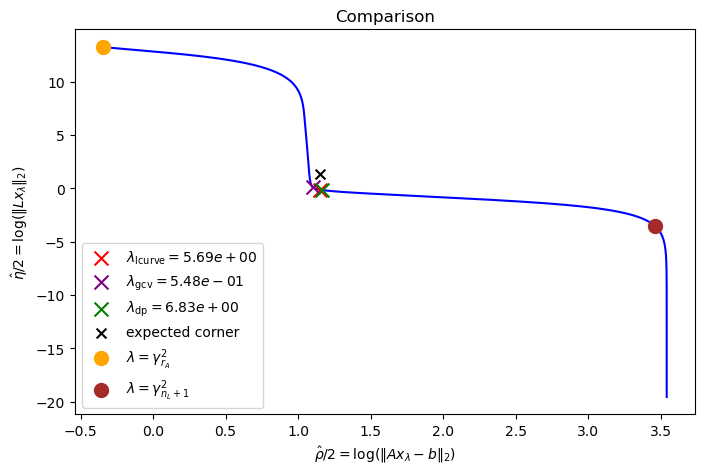

In [13]:
plot_all_methods(all_methods)
plot_all_methods(all_methods, plot_path="deblur_all_methods.png")

In [17]:
dp_lambdahs, dp_e_norms = rand_dp(tf, n_samples=10000)
lcorner_lambdahs, lcorner_e_norms = rand_lcorner(tf, n_samples=1000)
gcvmin_lambdahs, gcvmin_e_norms = rand_gcv(tf, n_samples=1000)

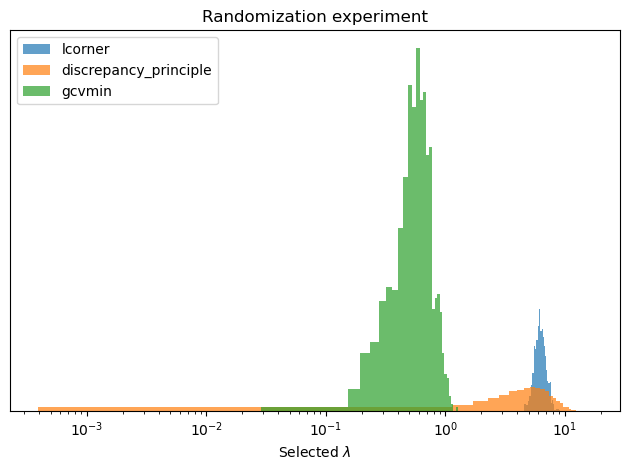

In [27]:
plt.hist(lcorner_lambdahs, bins=30, label="lcorner", density=True, alpha=0.7)
plt.hist(dp_lambdahs, bins=30, label="discrepancy_principle", density=True, alpha=0.7)
plt.hist(gcvmin_lambdahs, bins=30, label="gcvmin", density=True, alpha=0.7)
plt.yticks([])
plt.xscale("log")
plt.legend()
plt.title("Randomization experiment")
plt.xlabel("Selected $\lambda$")
plt.tight_layout()
plt.savefig("deblur_randomization_experiment.png", dpi=250, bbox_inches=None)
plt.show()

# TGSVD?

In [39]:
lambdahs = np.logspace(-10, 10, base=10, num=1000)
noise_var = noise_sigma**2

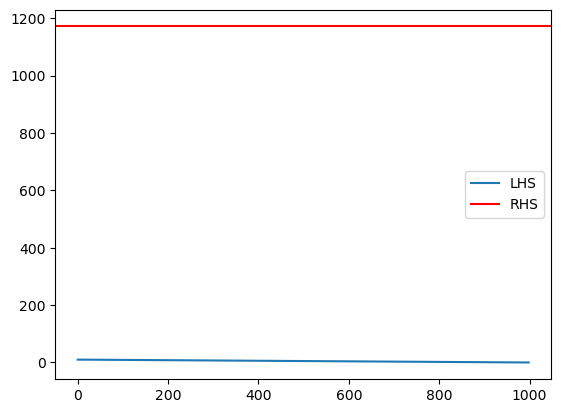

In [ ]:
k = 10
ks = np.arange(1, 1000)
seq1 = []
for k in ks:
    val = (tf.M - gsvd.n_L - k)*noise_var
    seq1.append(val)

#val2 = ( (gsvd.U2.T @ btrue)**2 ).sum() + tf.b_hat_perp_norm_squared
val2 = ( (gsvd.U2.T @ btrue)**2 ).sum() + tf.b_hat_perp_norm_squared

plt.plot(seq1, label="LHS")
plt.axhline(val2, label="RHS", color="red")
plt.legend()
plt.show()

In [54]:
ks = np.arange(1, 1000)
lhs2 = []
rhs2 = []
for k in ks:
    val = ( ( ( (gsvd.U2.T @ btrue)**2 ) / ( gsvd.gamma_check**2 ) )[:k] ).sum()
    lhs2.append(val)

    val = ( ( ( noise_var*np.ones_like(gsvd.gamma_check) ) / ( gsvd.gamma_check**2 ) )[:k] ).sum()
    rhs2.append(val)

In [89]:
# plt.plot(lhs2, label="LHS")
# plt.plot(rhs2, label="RHS")
# plt.legend()
# plt.yscale("log")
# plt.xlim(0,90)

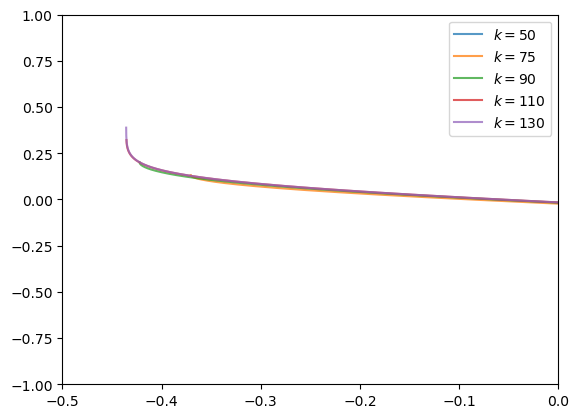

In [97]:
lambdahs = np.logspace(-10, 10, base=10, num=1000)

ks = [50, 75, 90, 110, 130]
for k in ks:
    data_fidelities = []
    regterms = []
    for lam in lambdahs:
        coeffs = ( lam/(gsvd.gamma_check**2 + lam) )**2 
        data_fid = ( ( coeffs*(gsvd.U2.T @ btrue)**2 )[:k] ).sum()
        data_fid += ( ( (gsvd.U2.T @ btrue)**2 )[k:] ).sum()
        data_fid += tf.b_hat_perp_norm_squared
        data_fidelities.append(data_fid)

        coeffs = ( (gsvd.gamma_check**2)/(lam + gsvd.gamma_check**2) )
        regterm = ( coeffs*( ( ( gsvd.U2.T @ btrue )**2 ) / (gsvd.gamma_check**2) ) )[:k].sum()
        regterms.append(regterm)

    plt.plot(0.5*np.log(data_fidelities), 0.5*np.log(regterms), label=f"$k = {k}$", alpha=0.75)

plt.xlim(-0.5, 0.0)
plt.ylim(-1,1)
plt.legend()

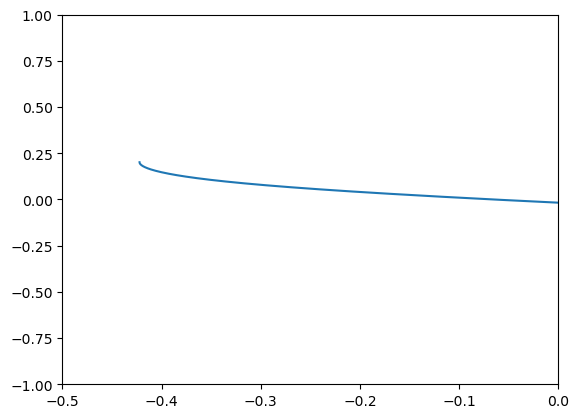

In [95]:
plt.plot(0.5*np.log(data_fidelities), 0.5*np.log(regterms))
plt.xlim(-0.5, 0.0)
plt.ylim(-1,1)
plt.show()

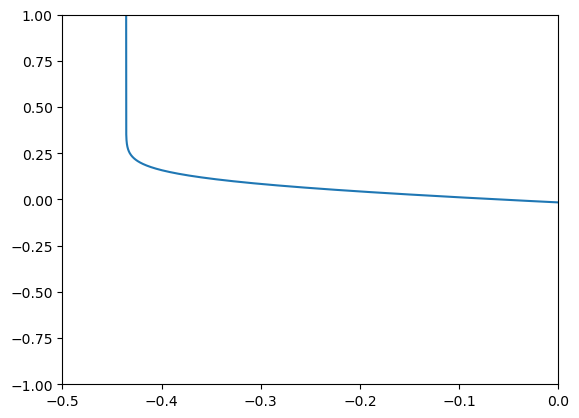

In [84]:
plt.plot(0.5*np.log(data_fidelities), 0.5*np.log(regterms))
plt.xlim(-0.5, 0.0)
plt.ylim(-1,1)
plt.show()

# Automatically checking DPC?

In [45]:
import numpy as np

def moving_geo_mean_rho(utb, gamma, q=3, delta=0.0, return_indices=False):
    """
    Compute rho_i = ( prod_{j=i-q}^{i+q} |u_j^T b| )^(1/(2q+1)) / gamma_i
    after removing entries with |u_i^T b| < delta. Only centers whose full
    window fits are computed, so the returned vector is shorter (no padding).

    Parameters
    ----------
    utb : (n,) array_like
        Entries u_j^T b.
    gamma : (n,) array_like
        Corresponding gamma_i (same length as utb).
    q : int
        Half-window size; window length is 2q+1.
    delta : float
        Threshold; drop indices with |u_i^T b| < delta before computing.
    return_indices : bool
        If True, also return the original indices of the centers.

    Returns
    -------
    rho : (n_valid,) ndarray
        Rho values for valid centers only (short vector).
    centers_idx : (n_valid,) ndarray of int, optional
        Returned iff return_indices=True; original indices of those centers.
    """
    utb = np.asarray(utb, dtype=float)
    gamma = np.asarray(gamma, dtype=float)
    if utb.ndim != 1 or gamma.ndim != 1 or utb.size != gamma.size:
        raise ValueError("utb and gamma must be 1-D arrays of the same length.")

    # 1) Filter by delta
    keep_mask = np.abs(utb) >= float(delta)
    kept_idx = np.flatnonzero(keep_mask)
    utb_f = utb[keep_mask]
    gamma_f = gamma[keep_mask]

    n = utb_f.size
    w = 2*q + 1
    if n < w:
        if return_indices:
            return np.array([], dtype=float), np.array([], dtype=int)
        return np.array([], dtype=float)

    # 2) Geometric mean via logs; handle zeros robustly
    a = np.abs(utb_f)
    zero_mask = (a == 0.0)
    safe_log = np.zeros_like(a)
    safe_log[~zero_mask] = np.log(a[~zero_mask])

    # Prefix sums for O(1) window aggregation
    csum_logs = np.concatenate(([0.0], np.cumsum(safe_log)))
    csum_zeros = np.concatenate(([0], np.cumsum(zero_mask.astype(int))))

    # Valid centers only: i = q ... n-q-1  (length n-2q)
    centers = np.arange(q, n - q)
    rho = np.empty(centers.size, dtype=float)

    for k, i in enumerate(centers):
        L, R = i - q, i + q
        zeros_in_win = csum_zeros[R + 1] - csum_zeros[L]
        if zeros_in_win > 0:
            gm = 0.0
        else:
            sum_logs = csum_logs[R + 1] - csum_logs[L]
            gm = np.exp(sum_logs / w)
        rho[k] = gm / gamma_f[i]

    if return_indices:
        # Map filtered centers back to original indices
        return rho, kept_idx[centers]
    return rho


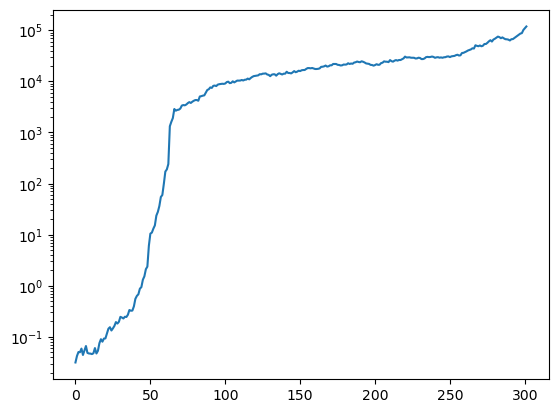

In [71]:
utb = tf.U2.T @ b
plt.semilogy(moving_geo_mean_rho(utb, tf.gamma_check, delta=1e-1, q=5))
plt.show()

In [30]:
utb = tf.U2.T @ btrue

In [27]:
np.linalg.svd( np.linalg.pinv(L) ).S

array([318.31001708, 159.15520489, 106.10368809,  79.57799515,
        63.66263174,  53.0524331 ,  45.47375719,  39.78978299,
        35.36894326,  31.83229765,  28.93870233,  26.52739471,
        24.48707764,  22.73825314,  21.2226227 ,  19.89646244,
        18.72633643,  17.68623898,  16.75563926,  15.9181126 ,
        15.16036287,  14.47151138,  13.84257142,  13.26605404,
        12.73566853,  12.24609198,  11.79279008,  11.37187624,
        10.97999998,  10.61425755,  10.27211986,   9.95137397,
         9.65007517,   9.36650755,   9.09915128,   8.84665543,
         8.60781509,   8.38155221,   8.16689928,   7.96298555,
         7.76902525,   7.58430739,   7.40818718,   7.24007839,
         7.07944695,   6.92580519,   6.77870697,   6.63774332,
         6.50253865,   6.37274742,   6.2480512 ,   6.12815605,
         6.01279021,   5.90170204,   5.79465823,   5.69144212,
         5.59185223,   5.49570103,   5.40281364,   5.3130269 ,
         5.2261883 ,   5.14215519,   5.06079399,   4.98

In [25]:
s = np.linalg.svd(L, compute_uv=False)
tol = 1e-12
s_pos = s[s > tol]
if s_pos.size == 0:
    result = 0.0
else:
    result = 1.0 / s_pos.min()

In [26]:
result

318.3100170835133

In [ ]:
1e-5

# Other

In [ ]:

def plot_gcv(gcv_data, plot_path=None):

    fig, axs = plt.subplots(figsize=(8,5))
    axs.scatter(gcv_data["gamma_sq_min"], gcv_data["gamma_sq_min_val"], label="$\lambda = \gamma_{r_A}^2$", color="orange", s=100, zorder=10, alpha=0.5)
    axs.scatter(gcv_data["gamma_sq_max"],  gcv_data["gamma_sq_max_val"], label="$\lambda = \gamma_{n_L + 1}^2$", color="brown", s=100, zorder=10, alpha=0.5)
    axs.plot( gcv_data["lambdahs"], gcv_data["gcv_vals"], color="blue")
    gcv_opt_lambdah = gcv_data["opt_lambdah"]
    axs.scatter(gcv_data["opt_lambdah"],  gcv_data["opt_lambdah_val"] , label=f"$\lambda = {gcv_opt_lambdah:.2e}$", color="red", s=100 , zorder=10)
    axs.set_xscale("log")
    axs.set_yscale("log")
    axs.set_title("GCV")
    axs.legend()

    if plot_path is not None:
        fig.savefig(plot_path, dpi=250)
        plt.close()
        return None
    else:
        plt.show()
        return None
    

In [ ]:

def plot_gcv(gcv_data, plot_path=None):

    fig, axs = plt.subplots(figsize=(8,5))
    axs.scatter(gcv_data["gamma_sq_min"], gcv_data["gamma_sq_min_val"], label="$\lambda = \gamma_{r_A}^2$", color="orange", s=100, zorder=10, alpha=0.5)
    axs.scatter(gcv_data["gamma_sq_max"],  gcv_data["gamma_sq_max_val"], label="$\lambda = \gamma_{n_L + 1}^2$", color="brown", s=100, zorder=10, alpha=0.5)
    axs.plot( gcv_data["lambdahs"], gcv_data["gcv_vals"], color="blue")
    gcv_opt_lambdah = gcv_data["opt_lambdah"]
    axs.scatter(gcv_data["opt_lambdah"],  gcv_data["opt_lambdah_val"] , label=f"$\lambda = {gcv_opt_lambdah:.2e}$", color="red", s=100 , zorder=10)
    axs.set_xscale("log")
    axs.set_yscale("log")
    axs.set_title("GCV")
    axs.legend()

    if plot_path is not None:
        fig.savefig(plot_path, dpi=250)
        plt.close()
        return None
    else:
        plt.show()
        return None
    

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(rho_hat_half, eta_hat_half, color="blue")
plt.xlabel("$\hat{\\rho}_{\lambda}/2 = \log \| A x_{\lambda} - b \|_2$")
plt.ylabel("$\hat{\\eta}_{\lambda}/2 = \log \| L x_{\lambda} - d \|_2$")
plt.title("L-curve for the 1D deblurring problem")
plt.tight_layout()
plt.savefig("deblur_lcurve.png", dpi=250, bbox_inches=None)
plt.show()

In [ ]:
ProjectedTikhonovFamily(A, L, V)